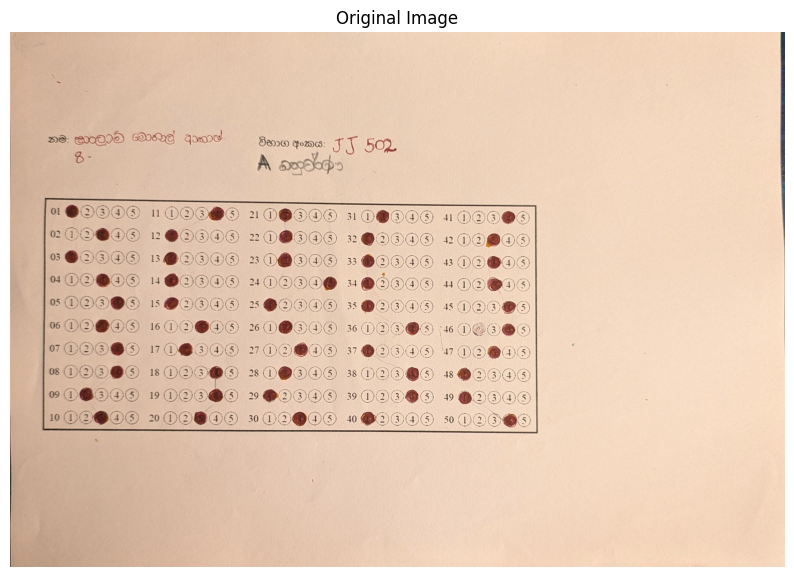

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('Data Set\Answer Scripts\Answer Scripts\A\JJ502.jpg')

# Use matplotlib to display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")  # Hide axes for better viewing
plt.show()

### Finding sheet corners

In [20]:
def find_sheet_corners(image):
    # Convert to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour is the answer sheet
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate the contour to find the corners
    perimeter = cv2.arcLength(largest_contour, True)
    corners = cv2.approxPolyDP(largest_contour, 0.02 * perimeter, True)

    if len(corners) == 4:
        return corners.reshape(4, 2)
    else:
        raise ValueError("Could not find the corners of the sheet")


# Find the corners of the sheet
sheet_corners = find_sheet_corners(image)

print(sheet_corners)


#cv2.waitKey(0)
#cv2.destroyAllWindows()

[[ 140  662]
 [ 133 1587]
 [2103 1599]
 [2097  691]]


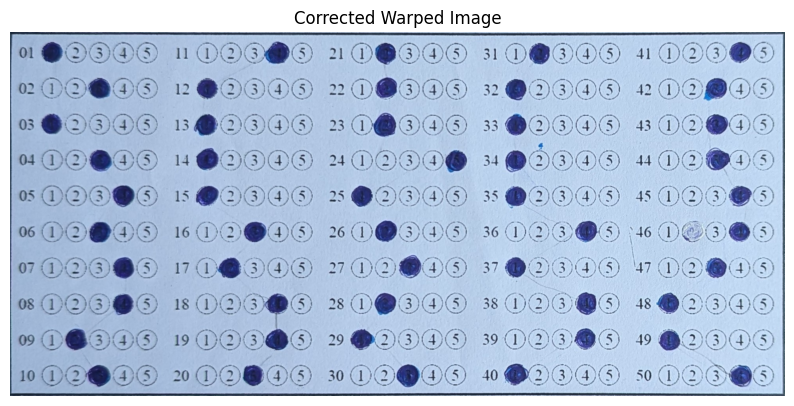

In [21]:
def warp_perspective(image, corners):
    # Define the known aspect ratio for the warped image (standard OMR sheet size)
    top_left, top_right, bottom_right, bottom_left = corners

    width = max(np.linalg.norm(top_right - top_left), np.linalg.norm(bottom_right - bottom_left))
    height = max(np.linalg.norm(top_right - bottom_right), np.linalg.norm(top_left - bottom_left))

    # Destination points for the warp
    destination_corners = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")

    # Perspective transform matrix
    M = cv2.getPerspectiveTransform(corners.astype(np.float32), destination_corners)
    warped = cv2.warpPerspective(image, M, (int(width), int(height)))

    return warped

# Warp the perspective to a known aspect ratio
warped_image = warp_perspective(image, sheet_corners)

# Optionally save or display the warped image
#cv2.imshow("Warped Image", warped_image)

# Rotate the image by 90 degrees clockwise to correct the orientation
warped_image_rotated = cv2.rotate(warped_image, cv2.ROTATE_90_CLOCKWISE)

# Flip the image horizontally to fix the mirroring
warped_image_corrected = cv2.flip(warped_image_rotated, 1)

# Convert the image to RGB for displaying with Matplotlib
warped_image_rgb = cv2.cvtColor(warped_image_corrected, cv2.COLOR_BGR2RGB)

# Use matplotlib to display the image
plt.figure(figsize=(10, 10))
plt.imshow(warped_image_rgb)
plt.title("Corrected Warped Image")
plt.axis("off")  # Hide axes for better viewing
plt.show()



In [ ]:
# Detect filled bubbles
#filled_bubbles = detect_filled_bubbles(warped_image)

#print(filled_bubbles)

# Print the results
#print("Filled Bubbles (Row, Column):")
#for bubble in filled_bubbles:
    #print(f"Question {bubble[0]}, Option {bubble[1]}")

def detect_filled_bubbles(warped_image, rows=10, columns=5):
    # Convert to grayscale and apply adaptive thresholding
    gray = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 180, 255, cv2.THRESH_BINARY_INV)

    # Define grid spacing based on the number of rows and columns
    height, width = thresh.shape
    bubble_height = height // rows
    bubble_width = width // columns

    filled_bubbles = []

    for row in range(rows):
        for col in range(columns):
            # Calculate the center of the bubble
            x_start = col * bubble_width
            y_start = row * bubble_height
            bubble_region = thresh[y_start:y_start + bubble_height, x_start:x_start + bubble_width]

            # Calculate the number of white pixels in the region
            total_pixels = bubble_region.size
            white_pixels = cv2.countNonZero(bubble_region)

            # If a significant portion of the bubble region is white, it's marked
            fill_ratio = white_pixels / total_pixels
            if fill_ratio > 0.5:  # This threshold can be tuned based on actual data
                filled_bubbles.append((row + 1, col + 1))  # Store the row and column (question, option)

    return filled_bubbles